# Explore RobinHood Popularity

This notebook consists of exploratory data analysis of RobinHood holdings data.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We're only interested in tickers that are discussed in wallstreetbets posts. Thus, we'll refer to the processed post data and only load unique tickers from that table.

In [3]:
# Load post data
posts = pd.read_csv('../data/tabular/wsb_posts/cleaned posts.csv',
                    index_col=0)
posts = posts.drop(columns=[col for col in posts.columns if 'Unnamed' in col])

posts['date'] = pd.to_datetime(posts['created_utc']).dt.date
posts = posts.drop(columns=['created_utc'])

# Calculate the number of unique tickers present in the post data
unique_tickers = (pd.Series(list(set(','.join(posts.tickers).split(','))), 
                            name='Ticker')
                  .sort_values())
n_unique = unique_tickers.shape[0]
print('There are {} unqiue tickers mentioned in WSB comments.'.format(n_unique))

There are 3294 unqiue tickers mentioned in WSB comments.


Next we'll load and process the number of accounts holding each ticker on each day. The result will be an $n$ x $m$ matrix where $n$ is the number of trading days in the sample and $m$ is the number tickers present in the comments (3294 calculated above). 

Reading this many files from disk can be slow so this program checks to see if the processed data already exists and loads that if it's available.

In [8]:

rh_prefix = '../data/tabular/popularity_export'
ticker = unique_tickers.iloc[0]

def aggregate_popularity(ticker):
    """Load the RH popularity export for a given ticker from csv and 
    aggregate to daily values, taking the last value for each day.
    
    @param ticker: [str] stock exchange symbol (ticker)
    @return [pd.DataFrame] RH Users holding on each trading day.
    """
    rh_prefix = '../../data/tabular/popularity_export'
    ticker_df = pd.read_csv('{}/{}.csv'.format(rh_prefix, ticker), 
                            parse_dates=[0])
    ticker_df = (
        ticker_df
        .groupby(ticker_df.timestamp.rename('date').dt.date)
        .last()
        [['users_holding']]
        .rename(columns={'users_holding': ticker})
    )
    return ticker_df


def load_popularities(tickers):
    """Iterates through and loads a list of tickers calling aggregate_popularity().
    Merges into one dataframe in which each column corresponds to the number of 
    accounts holding an associated ticker.
    
    @param tickers: [list:str] List of ticker strings
    @return [pd.DataFrame] Table of accounts holding for each ticker passed.
    """
    popularity_df = aggregate_popularity(tickers.iloc[0])
    
    for idx, ticker in tickers[1:].iteritems():
        next_ticker   = aggregate_popularity(ticker)
        popularity_df = pd.merge(popularity_df,
                                 next_ticker,
                                 left_index=True, 
                                 right_index=True,
                                 how='left')
        
    return popularity_df

popularity_csv = '../data/tabular/accounts_holding_table.csv'

if os.path.exists(popularity_csv):
    popularity_df = pd.read_csv(popularity_csv)
    popularity_df = popularity_df.set_index('date')
else:
    popularity_df = load_popularities(unique_tickers)
    popularity_df.to_csv(popularity_csv)

# Show the top five rows of the popularity dataframe, this gives the number of accounts
# holding each ticker at each date. Cast the whole thing to float because the tickers
# that are missing values will include NaNs and will wind up as floats anyway.
popularity_df = popularity_df.astype(float)
popularity_df.head()

,AAL,AAOI,AAP,AAPL,AAT,AAWW,AAXN,ABAX,ABB,ABBV,...,ZIV,ZIXI,ZLAB,ZNGA,ZSAN,ZTO,ZTS,ZUMZ,ZUO,ZYNE
date,,,,,,,,,,,,,,,,,,,,,
2018-05-02,3755.0,2711.0,302.0,150785.0,46.0,103.0,3164.0,37.0,1556.0,13307.0,...,192.0,2700.0,182.0,32425.0,1878.0,433.0,588.0,248.0,539.0,6127.0
2018-05-03,3775.0,2706.0,294.0,143747.0,47.0,109.0,3190.0,37.0,1550.0,13222.0,...,184.0,2726.0,181.0,32104.0,1826.0,430.0,609.0,251.0,546.0,6150.0
2018-05-04,3748.0,2719.0,289.0,141424.0,47.0,109.0,3174.0,36.0,1546.0,13214.0,...,183.0,2734.0,182.0,31734.0,1785.0,428.0,607.0,247.0,550.0,6140.0
2018-05-05,3748.0,2719.0,289.0,141436.0,47.0,109.0,3174.0,36.0,1546.0,13214.0,...,183.0,2734.0,182.0,31738.0,1785.0,428.0,607.0,247.0,550.0,6140.0
2018-05-06,3748.0,2719.0,289.0,141437.0,47.0,109.0,3174.0,36.0,1546.0,13214.0,...,183.0,2734.0,182.0,31749.0,1785.0,428.0,607.0,247.0,550.0,6140.0


We're going to use the accounts-holding data from RobinHood to come up with a target variable that we can use to train an NLP model. The following cells look at the distribution of accounts holder over all stocks at a single point in time and for individual stocks over time. 

Stock popularity is a classic case of a [power law distribution](https://en.wikipedia.org/wiki/Power_law]). The histogram on the top left shows accounts holding against counts of accounts-holding while the histogram on the top right shows log-accounts-holding against counts of log accounts holding. The log-transform makes the accounts-holding data a little more manageable but, as the Shapiro-Wilk test in the following cell shows, it's still doesn't follow a Normal distribution. 

Non-normality may not be a problem depending on our choice of model later but it's useful in determining benchmarks and building an intuition for the dynamics of the system. To further understand the system dynamics, the cross sectional distribution of  change in number of accounts holding from the first to second day and the log-change are plotted in the second row. Note that though the distribution of differenced series on the bottom right is symmetric, its tails are still very heavy and therefore non-normal. This precludes inference with linear models (such as ARIMA/SARIMA/SARIMAX) though such approaches can still be used for forecasting. Note that the cross-sectional distribution of changes in accounts-holding changes substantially from the first to the 9th day as shown in the plot on the bottom right.

/Users/acelder/venvs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/acelder/venvs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


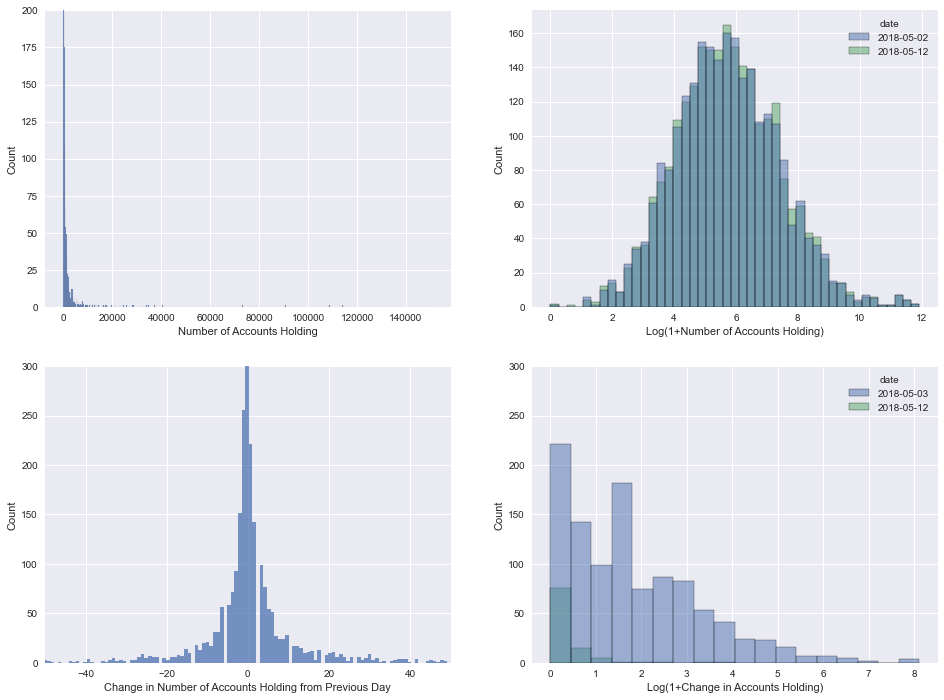

In [31]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    sns.histplot(data=popularity_df.iloc[0].values, ax=ax[0,0])
    sns.histplot(data=(popularity_df
                       .iloc[[0, 10]]
                       .apply(lambda x: np.log(1 + x))
                       .transpose()),
                 ax=ax[0,1])
    sns.histplot(data=popularity_df.diff().iloc[1].values, ax=ax[1,0])
    sns.histplot(data=(popularity_df.diff()
                       .iloc[[1,10]]
                       .apply(lambda x: np.log(x))
                       .transpose()),
                 ax=ax[1,1])
    ax[0,0].set_xlabel('Number of Accounts Holding')
    ax[0,0].set_ylim([0, 200])
    ax[0,1].set_xlabel('Log(1+Number of Accounts Holding)')
    ax[1,0].set_xlabel('Change in Number of Accounts Holding from Previous Day')
    ax[1,0].set_ylim([0, 300])
    ax[1,0].set_xlim([-50, 50])
    ax[1,1].set_xlabel('Log(1+Change in Accounts Holding)')
    ax[1,1].set_ylim([0, 300])
    plt.show()
    
    
    

In [30]:
from scipy.stats import shapiro

alpha = 0.05
stat, p_value = shapiro(np.log(1 + popularity_df.iloc[0].values))
print(f'Shapiro-Wilk Test P-Value: {p_value}')
print(('Reject H0 that the level distribution follows a normal distribution' 
       if p_value < alpha else 
       'Accept H0 that the level distribution follows a normal distribution'))

stat, p_value = shapiro(popularity_df.diff().iloc[1].values)
print(f'Shapiro-Wilk Test P-Value: {p_value}')
print(('Reject H0 that the differenced distribution follows a normal distribution' 
       if p_value < alpha else 
       'Accept H0 that the differenced distribution follows a normal distribution'))



Shapiro-Wilk Test P-Value: 1.0
Accept H0 that the level distribution follows a normal distribution
Shapiro-Wilk Test P-Value: 1.0
Accept H0 that the differenced distribution follows a normal distribution


Log numbers of accounts holding are plotted for a selection of stocks of different starting popularity. Note that the popularity of all stocks increase over time as the app itself gains new users. Our predictive model should normalize this effect and also account for relative changes in popularity, since what we really care about is predicting if one stock will change in popularity relative to others using unstructured text data.

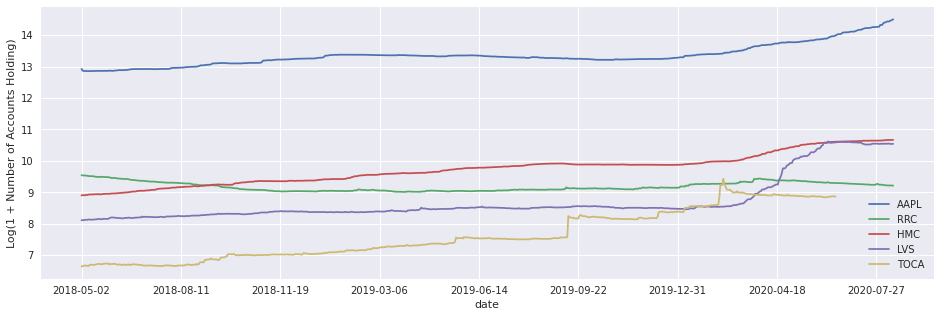

In [34]:
first_date_rank = popularity_df.iloc[0].rank() 
plot_stocks = [
    popularity_df.columns[first_date_rank == int(frac*first_date_rank.max())][0]
    for frac in [1.0, 0.95, 0.9, 0.8, 0.5]
]


plot_stocks_pop = popularity_df[plot_stocks]

with plt.style.context('seaborn'):
    plot_stocks_pop.apply(lambda x: 1 + np.log(x)).plot(figsize=(16,5))
    plt.gca().set_ylabel('Log(1 + Number of Accounts Holding)')